# The effectiveness of prescribed burns on preventing the spread of wildfires

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

Prescribed burns are considered to be a crucial wildfire prevention method. The intentional, controlled application of fire to regions of land removes dry tinder and vegetation, which serve as fuel in wildfires. Given the prevalence of wildfires in California, as well as their devastating impact on people and the environment, it is important to determine whether prescribed burns are effective in preventing and suppressing wildfires. In this project, we explore the relationship between prescribed burns and wildfire burn areas in California by analyzing wildfire and prescribed burn data over the past 100 years. The effectiveness of prescribed burns preventing the spread of fires seems to depend on the size of the fire compared to the burn, but more data is needed to understand what types of burn strategies are best.

# Names

- Michael Colbath
- Laticia Long
- Sungjun Kim
- James Riddell

<a id='research_question'></a>
# Research Question

#### Do prescribed burn treatments prevent the spread of wildfires through treated areas?

<a id='background'></a>

## Background & Prior Work

Prescribed burns have been done by indigenous peoples for thousands of years. Burns are done because many terrestrial ecosystems need to regularly burn as part of their natural cycle [1]. Due to western colonization, prescribed burns happen far less, and natural wildfires are cut short before they can reset ecosystems, which has caused a buildup of dry lumber all across California. A combination of the active prevention of wildfires during the 20th century, recent housing development at the wildfire-urban interface, and anthropogenic climate change has increased the frequency and severity of wildfires. Due to these increasing risks, communities have begun working with local indigenous communities, environmental groups, and fire departments to reintroduce controlled burns [2]. However, there has been pushback from insurance companies [3]. While models have been devised to predict the area burned from wildfires [4], little analysis has been done on the cost-benefit of controlled burns in California. One study discovered that controlled burns significantly reduced the cost of fires, but preventative measures are restricted by limited budgets [5].  

Here, we aim to answer the question: To what extent are prescribed burns effective at reducing the spread of wildfires? We will build a statistical model using the CalFire dataset [6] to investigate the relationship between prescribed burn and wildfire burn area throughout California. We will also explore our question in the context of increased building at the wildfire-urban interface and discuss socially equitable solutions to combat increasing wildfires. 

References:
1. Cleaves, D. A., Martinez, J., &amp; Haines, T. K. (2012). Influences on prescribed burning activity and costs in the National Forest System. https://doi.org/10.2737/srs-gtr-37 
2. Fernandes, P. M., &amp; Botelho, H. S. (2003). A review of prescribed burning effectiveness in fire hazard reduction. International Journal of Wildland Fire, 12(2), 117. https://doi.org/10.1071/wf02042 
3. Gabbert, B. (2021, May 5). Legislation Reintroduced to Boost Prescribed Fire Activities. Retrieved October 22, 2021, from https://wildfiretoday.com/2021/05/21/legislation-reintroduced-to-boost-prescribed-fire-activities/. 
4. Ledig, T. F., &amp; Neale, D. B. (1998). Pacific Southwest Research Station. USDA Forest Service. Retrieved October 22, 2021, from https://www.fs.fed.us/psw/publications/documents/psw_gtr170/. 
5. Smith, H. (2021, October 7). Newsom signs 'monumental' law paving way for more prescribed burns. Los Angeles Times. Retrieved October 22, 2021, from https://www.latimes.com/california/story/2021-10-07/newsom-signs-fire-law-paving-way-for-more-prescribed-burns. 
6. Wood, D. A. (2021). Prediction and data mining of burned areas of forest fires: Optimized data matching and mining algorithm provides valuable insight. Artificial Intelligence in Agriculture, 5, 24–42. https://doi.org/10.1016/j.aiia.2021.01.004 


# Hypothesis


Hypothesis: Prescribed burns prevent the spread of wildfires through treated areas because they will have previously burned away the fuel in the area, effectively starving the wildfire and preventing it from reaching more fuel. Fires that start in burned areas will have no fuel to grow.

Alternative Hypothesis/Null: Prescribed burns have no significant impact on the spread of wildfires through treated areas because the fires are either much larger than the treated area and burn around it, or prescribed burns may not be effective enough at starving wildfires that encounter treated areas.

# Dataset(s)

- Dataset Name: **California_Fire_Perimeters_(all).csv**
- Link to the dataset: https://gis.data.cnra.ca.gov/maps/CALFIRE-Forestry::california-wildland-fire-perimeters-all/about
- Number of observations: 21318 (15947 after cleaning)
- Updated annually with fire perimeters from previous years. It includes California fire data from the years 1878-2020, and includes data like the start and contained dates, cause of the fire, and burn area.


- Dataset Name: **California_Wildland_Fire_Perimeters_All.csv**
- Link to the dataset: https://gis.data.cnra.ca.gov/maps/CALFIRE-Forestry::california-wildland-fire-perimeters-all/about
- Number of observations: 6412 (5498 after cleaning)
- Updated annually with prescribed burn perimeters from previous years. It includes data like start and end dates, cause of fire, and burn area. We will be using their REST API to find out the location of the wildfires corresponding to each wildfire case.


- Dataset Name: **Fire20_1.gdb**
- Link to the dataset: https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::prescribed-burns-1/api 
- Number of observations:
- Database specifically for GIS data, and is called the Fire Perimeter Database. The database is maintained as an ESRI ArcGIS File Geodatabase. The dataset has three key features: fire perimeters, prescribed burn perimeters, and non-prescribed fuel reductions that were initially in the database (but new ones have not been added).


All three datasets categorize fires by object ID. We plan on merging datasets 1, 2, and 3. Our third dataset has additional geographic data, such as location and shape, which are not included in the other two datasets.

# Setup

In [293]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
import tarfile
import time
import math
from scipy.stats import ks_2samp
import geopandas
import shapely
from shapely.geometry import Point, Polygon, LineString, GeometryCollection, shape

# Data Cleaning

Cleaning steps:
1. Load in wildfire and prescribed burn data
2. Remove unnecessary and NaN columns
3. Convert columns to appropriate datatypes
4. Webscrape GIS coordinates for each fire and burn
5. Combine coordinates with first dataframe

In [289]:
# load data
df_fires = pd.read_csv("California_Fire_Perimeters_(all).csv") # wildfires
df_prescribed = pd.read_csv("California_Wildland_Fire_Perimeters_All.csv") # prescribed burns

# rounding values to 2 decimal places
pd.set_option('precision', 2)
df_prescribed.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,TREATMENT_ID,TREATMENT_NAME,TREATMENT_TYPE,START_DATE,END_DATE,TREATED_AC,GIS_ACRES,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS,Shape__Area,Shape__Length
0,6156,2020,CA,CDF,AEU,10509,Jan 31 2020 Broadcast,3.0,2020/01/31 00:00:00+00,2020/01/31 00:00:00+00,15.0,15.05,NaN,NaN,NaN,100262.79,1752.95
1,6157,2020,CA,PVT,AEU,10572,2020 Fuels Reduction,3.0,2020/02/13 00:00:00+00,2020/02/13 00:00:00+00,22.3,36.74,NaN,NaN,NaN,245805.56,3448.16
2,6158,2020,CA,CDF,AEU,10630,Feb 2020 Broadcast,3.0,2020/02/13 00:00:00+00,2020/02/18 00:00:00+00,22.4,38.84,NaN,NaN,NaN,257040.12,5011.40
3,6159,2020,CA,CDF,AEU,10639,Feb 2020 Broadcast,3.0,2020/02/11 00:00:00+00,2020/02/20 00:00:00+00,75.5,75.50,NaN,NaN,NaN,503008.88,5028.25
4,6160,2020,CA,CDF,AEU,10780,Mar 3 2020 Broadcast,3.0,2020/03/03 00:00:00+00,2020/03/03 00:00:00+00,61.8,61.77,NaN,NaN,NaN,411511.35,3552.71


In [3]:
# Dropping empty columns INC_NUM, and FIRE_NUM, and the useless columns COMMENTS and C_METHOD
df_fires = df_fires.drop(['INC_NUM', 'FIRE_NUM', 'COMMENTS', 'C_METHOD'], axis=1)
df_prescribed = df_prescribed.drop(['TREATMENT_TYPE', 'TREATMENT_ID', 'RX_CONSUM', 'PRE_CON_CLASS', 'POST_CON_CLASS'], axis=1)
df_fires.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_Length,SHAPE_Area
0,21440,2020.0,CA,CDF,NEU,NELSON,2020/06/18 00:00:00+00,2020/06/23 00:00:00+00,11.0,110.0,109.60,1.0,4179.74,-7.33e+05
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020/06/01 00:00:00+00,2020/06/04 00:00:00+00,2.0,670.0,685.59,1.0,12399.38,-4.58e+06
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020/08/10 00:00:00+00,2020/03/01 00:00:00+00,14.0,26.0,27.30,1.0,2119.19,-1.82e+05
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020/03/31 00:00:00+00,2020/04/01 00:00:00+00,9.0,13.0,12.93,1.0,2029.52,-8.67e+04
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020/04/14 00:00:00+00,2020/04/19 00:00:00+00,18.0,10.3,10.32,1.0,1342.74,-7.02e+04


In [4]:
# Dropping any rows missing our most important values
pre_removal = df_fires.shape
df_fires = df_fires.dropna(axis=0, subset=['OBJECTID', 'ALARM_DATE', 'GIS_ACRES', 'SHAPE_Area'])
df_prescribed = df_prescribed.dropna(axis=0, subset=['OBJECTID', 'START_DATE', 'GIS_ACRES', 'Shape__Area'])

In [5]:
# initial look at data distribution
df_fires.describe()

,OBJECTID,YEAR_,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_Length,SHAPE_Area
count,15947.00,15947.00,15919.00,8148.00,1.59e+04,15786.00,1.59e+04,1.59e+04
mean,33105.84,1987.08,8.60,2409.86,2.02e+03,1.01,1.17e+04,-1.31e+07
std,6135.81,26.62,5.34,15948.34,1.48e+04,0.12,3.38e+04,9.92e+07
min,21440.00,1898.00,1.00,0.00,1.36e-03,1.00,1.10e+01,-7.12e+09
25%,28546.50,1970.00,2.00,15.00,2.07e+01,1.00,1.79e+03,-3.78e+06
50%,33529.00,1994.00,9.00,60.00,1.19e+02,1.00,4.44e+03,-7.54e+05
75%,38478.50,2009.00,14.00,370.62,5.89e+02,1.00,1.04e+04,-1.35e+05
max,42764.00,2020.00,19.00,499945.00,1.03e+06,2.00,1.70e+06,1.45e+05


In [6]:
# Removing the not implemented time signature from each date
df_fires['ALARM_DATE'] = df_fires['ALARM_DATE'].astype(str).str[:10]
df_fires['CONT_DATE'] = df_fires['CONT_DATE'].astype(str).str[:10]
df_prescribed['START_DATE'] = df_prescribed['START_DATE'].astype(str).str[:10]
df_prescribed['END_DATE'] = df_prescribed['END_DATE'].astype(str).str[:10]
df_fires.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_Length,SHAPE_Area
0,21440,2020.0,CA,CDF,NEU,NELSON,2020/06/18,2020/06/23,11.0,110.0,109.60,1.0,4179.74,-7.33e+05
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020/06/01,2020/06/04,2.0,670.0,685.59,1.0,12399.38,-4.58e+06
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020/08/10,2020/03/01,14.0,26.0,27.30,1.0,2119.19,-1.82e+05
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020/03/31,2020/04/01,9.0,13.0,12.93,1.0,2029.52,-8.67e+04
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020/04/14,2020/04/19,18.0,10.3,10.32,1.0,1342.74,-7.02e+04


In [7]:
# fixing a negative area data mistake in the shape column
df_fires['SHAPE_Area'] = df_fires['SHAPE_Area'].abs()
df_prescribed['Shape__Area'] = df_prescribed['Shape__Area'].abs()
df_fires.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_Length,SHAPE_Area
0,21440,2020.0,CA,CDF,NEU,NELSON,2020/06/18,2020/06/23,11.0,110.0,109.60,1.0,4179.74,7.33e+05
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020/06/01,2020/06/04,2.0,670.0,685.59,1.0,12399.38,4.58e+06
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020/08/10,2020/03/01,14.0,26.0,27.30,1.0,2119.19,1.82e+05
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020/03/31,2020/04/01,9.0,13.0,12.93,1.0,2029.52,8.67e+04
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020/04/14,2020/04/19,18.0,10.3,10.32,1.0,1342.74,7.02e+04


In [8]:
# fixing naming inconsistencies
df_fires = df_fires.rename(columns={'YEAR_':'YEAR', 'SHAPE_Length':'SHAPE_LENGTH', 'SHAPE_Area':'SHAPE_AREA', 
                                    'ALARM_DATE':'START_DATE', 'CONT_DATE':'END_DATE'})
df_prescribed = df_prescribed.rename(columns={'YEAR_':'YEAR', 'Shape__Length':'SHAPE_LENGTH', 'Shape__Area':'SHAPE_AREA', 
                                              'TREATMENT_NAME':'FIRE_NAME', 'TREATED_AC':'REPORT_AC'})

In [9]:
# combining datasets 1 and 2 into one
df_together = pd.concat([df_fires, df_prescribed])
df_together.head()

,OBJECTID,YEAR,STATE,AGENCY,UNIT_ID,FIRE_NAME,START_DATE,END_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_LENGTH,SHAPE_AREA
0,21440,2020.0,CA,CDF,NEU,NELSON,2020/06/18,2020/06/23,11.0,110.0,109.60,1.0,4179.74,7.33e+05
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020/06/01,2020/06/04,2.0,670.0,685.59,1.0,12399.38,4.58e+06
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020/08/10,2020/03/01,14.0,26.0,27.30,1.0,2119.19,1.82e+05
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020/03/31,2020/04/01,9.0,13.0,12.93,1.0,2029.52,8.67e+04
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020/04/14,2020/04/19,18.0,10.3,10.32,1.0,1342.74,7.02e+04


In [10]:
# confirm all IDs are unique
all(df_fires['OBJECTID'].value_counts() == 1)

True

The above data contains almost everything we want, but is missing a crucial feature: GIS coordinates. These coordinates will help us figure out the extent of the fires and where fires and prescribed burns overlap, which is essential for answering our question if prescribed burns have a measurable effect on wildfire area burned. To get this data, we need to use the REST API from ARCGIS, which the next section will describe.

#### Acquire data from ARCGIS API

In [11]:
# getting ID's for each group of fires
object_ids = df_fires['OBJECTID']
prescribed_ids = df_prescribed['OBJECTID']

In [12]:
# Bin object ids into groups of 50 since that is the max URL query size (empirically tested)
binned_50 = list(zip(*(iter(object_ids),) * 50))
prescribed_50 = list(zip(*(iter(prescribed_ids),) * 50))

In [13]:
# create html query string; formula discovered from playing with ARCGIS API
html_formatted = ['OBJECTID%20%3D%20%27' + str(val) + '%27%20OR%20' for val in binned_50[0]]
html_merged = ''.join(html_formatted)[:-8]

prescribed_html_formatted = ['OBJECTID%20%3D%20%27' + str(val) + '%27%20OR%20' for val in prescribed_50[0]]
prescribed_html_merged = ''.join(prescribed_html_formatted)[:-8]

In [14]:
# Try and request the first 50.
url = 'https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters_FS/FeatureServer/0/query?where=%20(' + html_merged + ')%20&outFields=*&outSR=4326&f=json'
r = requests.get(url)
x = r.text

In [15]:
# Try and request the first 50 prescribed (different URL)
url = 'https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters_FS/FeatureServer/1/query?where=%20(' + prescribed_html_merged + ')%20&outFields=*&outSR=4326&f=json'
r = requests.get(url)
x = r.text

In [16]:
# Generate query URLs from the list of fire Object IDs doing 50 at a time.
x_lst = []
for lst in binned_50:
    html_formatted = ['OBJECTID%20%3D%20%27' + str(val) + '%27%20OR%20' for val in lst]
    html_merged = ''.join(html_formatted)[:-8]
    url = 'https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters_FS/FeatureServer/0/query?where=%20(' + html_merged + ')%20&outFields=*&outSR=4326&f=json'
    r = requests.get(url)
    x = r.text
    x_lst.append(x)
    time.sleep(0.5)

In [17]:
# Generate query URLs from the list of prescribed burn Object IDs doing 50 at a time.
prescribed_lst = []
for lst in prescribed_50:
    html_formatted = ['OBJECTID%20%3D%20%27' + str(val) + '%27%20OR%20' for val in lst]
    html_merged = ''.join(html_formatted)[:-8]
    url = 'https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters_FS/FeatureServer/1/query?where=%20(' + html_merged + ')%20&outFields=*&outSR=4326&f=json'
    r = requests.get(url)
    x = r.text
    prescribed_lst.append(x)
    time.sleep(1)

In [ ]:
# write each output to its own JSON file
for l in range(len(x_lst)):
    gis_coords = open("fire_perimeters_with_coords/fire_perimeters_with_coords_" + str(l) + ".json", 'w')
    gis_coords.write(x_lst[l])
    gis_coords.close()

In [21]:
# do same for prescribed burns
for l in range(len(prescribed_lst)):
    gis_coords = open("fire_perimeters_with_coords/prescribed_burn_perimeters_with_coords_" + str(l) + ".json", 'w')
    gis_coords.write(prescribed_lst[l])
    gis_coords.close()

Now that we've written all the URL queries to JSON files, we no longer need to query the online database again. From here, we can simply load our newly scraped data from the local JSON files with the cell below. Since we cannot host all the files on github in their extracted form and had difficulty figuring out how to extract them here, if you are not running this code from the beginning you will need to extract the tarfile fire_perimeters_with_coords.tar.gz

In [299]:
# load query outputs into a list
all_attributes = []
for i in range(318):
    f = open('fire_perimeters_with_coords/fire_perimeters_with_coords_' + str(i) + '.json', "r")
 
    # Reading from file
    y = json.loads(f.read())
    all_attributes += y['features']
for i in range(109):
    f = open('fire_perimeters_with_coords/prescribed_burn_perimeters_with_coords_' + str(i) + '.json', "r")
 
    # Reading from file
    y = json.loads(f.read())
    all_attributes += y['features']

FileNotFoundError: [Errno 2] No such file or directory: 'fire_perimeters_with_coords/fire_perimeters_with_coords_0.json'

In [23]:
# concatenate all query outputs into one dataframe
df_gis = pd.DataFrame()
for attribute in all_attributes:
    df_gis = pd.concat([df_gis, pd.DataFrame(attribute).transpose()])

In [24]:
df_gis.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,rings,TREATMENT_ID,TREATMENT_NAME,TREATMENT_TYPE,START_DATE,END_DATE,TREATED_AC,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS
attributes,21440,2020,CA,CDF,NEU,NELSON,00013212,1592438400000,1592870400000,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geometry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[[-121.34841599559529, 38.88999089961929], [-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attributes,21441,2020,CA,CDF,NEU,AMORUSO,00011799,1590969600000,1591228800000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geometry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[[[-121.35276437696633, 38.8203885779964], [-1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attributes,21442,2020,CA,CDF,NEU,ATHENS,00018493,1597017600000,1583020800000,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# rings are in their own geometry index row. Shift rings column up by one
df_gis['rings_shifted'] = df_gis['rings'].shift(-1)

In [26]:
# drop columns we are not interested in or are empty
df_gis.drop(columns=['TREATMENT_TYPE',
                     'TREATMENT_ID',
                     'RX_CONSUM',
                     'PRE_CON_CLASS',
                     'POST_CON_CLASS',
                     'INC_NUM',
                     'COMMENTS',
                     'C_METHOD',
                     'FIRE_NUM',
                     'rings'],
            inplace=True)

In [27]:
# drop every other row (geometry), as it is empty now after rings got shifted
df_standard = (
    df_gis.iloc[::2, :]
    .reset_index(drop=True).rename(columns={'rings_shifted': 'rings'})
)

df_standard.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,Shape__Area,Shape__Length,TREATMENT_NAME,START_DATE,END_DATE,TREATED_AC,rings
0,21440,2020,CA,CDF,NEU,NELSON,1592438400000,1592870400000,11,110.0,109.6,1,733134.7,4179.74,NaN,NaN,NaN,NaN,"[[[-121.34841599559529, 38.88999089961929], [-..."
1,21441,2020,CA,CDF,NEU,AMORUSO,1590969600000,1591228800000,2,670.0,685.59,1,4578171.9,12399.38,NaN,NaN,NaN,NaN,"[[[-121.35276437696633, 38.8203885779964], [-1..."
2,21442,2020,CA,CDF,NEU,ATHENS,1597017600000,1583020800000,14,26.0,27.3,1,182387.64,2119.19,NaN,NaN,NaN,NaN,"[[[-121.33334769903689, 38.84558416014423], [-..."
3,21443,2020,CA,CDF,NEU,FLEMING,1585612800000,1585699200000,9,13.0,12.93,1,86679.42,2029.52,NaN,NaN,NaN,NaN,"[[[-121.27318028493654, 38.96308176928564], [-..."
4,21444,2020,CA,CDF,NEU,MELANESE,1586822400000,1587254400000,18,10.3,10.32,1,70179.12,1342.74,NaN,NaN,NaN,NaN,"[[[-121.30066740042903, 39.48714167732556], [-..."


In [28]:
# Assigning fires either fire or prescribed burn based on type of fire. They are split by their OBJECTID ranges.
# max prescribed ID is 12937
max_prescribed_id = 12937
df_standard['FIRE_TYPE'] = (
    df_standard['OBJECTID']
    .apply(lambda x: 'prescribed_burn' if x <= max_prescribed_id else 'fire')
)

In [10]:
# Combining df_together and the rings portion of the GIS data

df_id_ring = df_standard[['OBJECTID', 'rings', 'FIRE_TYPE']]
df_id_ring.head()

# df together is defined above and is prescribed burns and wildfires combined
OBJECTIDS = list(df_id_ring['OBJECTID'])

# there are around 20 IDs that dont match up here
df_together = df_together[df_together.OBJECTID.isin(OBJECTIDS)]
ringList = df_id_ring['rings'].values
df_together['RINGS'] = ringList
df_together['FIRE_TYPE'] = list(df_id_ring['FIRE_TYPE'].values)
df_together.head()
df = df_together
# Final Cleanup of NaN columns
df.dropna(axis=1, how='all', inplace=True)

#Streamlining some code
df.to_csv('fires_and_burns.csv.gz', compression='gzip', index=False)

NameError: name 'df_all_cleaned' is not defined

In [14]:
data.head()

,OBJECTID,YEAR,STATE,AGENCY,UNIT_ID,FIRE_NAME,START_DATE,END_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_LENGTH,SHAPE_AREA,RINGS,FIRE_TYPE
0,21440,2020.0,CA,CDF,NEU,NELSON,2020/06/18,2020/06/23,11.0,110.0,109.60250,1.0,4179.743142,7.331347e+05,"[[[-121.34841599559529, 38.88999089961929], [-...",fire
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020/06/01,2020/06/04,2.0,670.0,685.58502,1.0,12399.375391,4.578172e+06,"[[[-121.35276437696633, 38.8203885779964], [-1...",fire
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020/08/10,2020/03/01,14.0,26.0,27.30048,1.0,2119.194120,1.823876e+05,"[[[-121.33334769903689, 38.84558416014423], [-...",fire
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020/03/31,2020/04/01,9.0,13.0,12.93155,1.0,2029.524881,8.667942e+04,"[[[-121.27318028493654, 38.96308176928564], [-...",fire
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020/04/14,2020/04/19,18.0,10.3,10.31596,1.0,1342.742903,7.017912e+04,"[[[-121.30066740042903, 39.48714167732556], [-...",fire


Most of the data cleaning at this point is done, but some values like the geometry object "RINGS" and dates need to be evaluated after loading from CSV. When doing the analysis, we can start here so that we don't need to scrape the data again.

In [2]:
# load in dataset for EDA
df = pd.read_csv('fires_and_burns.csv.gz', compression='gzip')
df.head()

,OBJECTID,YEAR,STATE,AGENCY,UNIT_ID,FIRE_NAME,START_DATE,END_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_LENGTH,SHAPE_AREA,FIRE_TYPE,RINGS
0,21440,2020.0,CA,CDF,NEU,NELSON,2020/06/18,2020/06/23,11.0,110.0,109.60250,1.0,4179.743142,7.331347e+05,fire,"[[[-121.34841599559529, 38.88999089961929], [-..."
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020/06/01,2020/06/04,2.0,670.0,685.58502,1.0,12399.375391,4.578172e+06,fire,"[[[-121.35276437696633, 38.8203885779964], [-1..."
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020/08/10,2020/03/01,14.0,26.0,27.30048,1.0,2119.194120,1.823876e+05,fire,"[[[-121.33334769903689, 38.84558416014423], [-..."
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020/03/31,2020/04/01,9.0,13.0,12.93155,1.0,2029.524881,8.667942e+04,fire,"[[[-121.27318028493654, 38.96308176928564], [-..."
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020/04/14,2020/04/19,18.0,10.3,10.31596,1.0,1342.742903,7.017912e+04,fire,"[[[-121.30066740042903, 39.48714167732556], [-..."


In [3]:
# use eval() to convert string form to list
df.RINGS = df.RINGS.apply(lambda x: eval(x))

In [5]:
# What is the datatype of START_DATE and END_DATE?
type(df.START_DATE[0])

str

In [6]:
# convert to DateTime objects
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%Y/%m/%d', errors='coerce')
df.START_DATE.head()

0   2020-06-18
1   2020-06-01
2   2020-08-10
3   2020-03-31
4   2020-04-14
Name: START_DATE, dtype: datetime64[ns]

In [7]:
# check for NaTs in case dates were not in YYYY/mm/dd format
df.loc[pd.isnull(df.START_DATE)]

,OBJECTID,YEAR,STATE,AGENCY,UNIT_ID,FIRE_NAME,START_DATE,END_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_LENGTH,SHAPE_AREA,FIRE_TYPE,RINGS
15816,42633,2019.0,CA,CCO,ORC,BLUE DIAMOND,NaT,0219/05/29,16.0,NaN,2.29694,1.0,1125.79746,13487.243999,fire,"[[[-117.69594457210428, 33.772833825516976], [..."


It appears this one fire had its dates entered wrong. We can ignore it for date-time purposes since it will have a negligible affect on our analysis.

In [9]:
df['END_DATE'] = pd.to_datetime(df['END_DATE'], format='%Y/%m/%d', errors='coerce')

In [28]:
# code causes; corresponding values were pulled from the data table within the GIS webapp
# https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::fire-perimeters/explore
causes = {
    1: 'Lightning',
    2: 'Equipment Use',
    3: 'Smoking',
    4: 'Campfire',
    5: 'Debris',
    6: 'Railroad',
    7: 'Arson',
    8: 'Playing with fire',
    9: 'Miscellaneous',
    10: 'Vehicle',
    11: 'Powerline',
    12: 'Firefighter Training',
    13: 'Non-Firefighter Training',
    14: 'Unknown / Unidentified',
    15: 'Structure',
    16: 'Aircraft',
    17: 'Could not retreive cause',
    18: 'Escaped Prescribed Burn',
    19: 'Illegal Alien Campfire',
}

In [29]:
def get_cause(x):
    '''
    A function that returns the cause of the fire
    based on the cause ID.
    '''
    try:
        out = causes[x]
    except KeyError:
        out = np.nan
    return out

In [30]:
cause_str = df['CAUSE'].apply(get_cause)
df['CAUSE'] = cause_str

In [221]:
df.head()

,OBJECTID,YEAR,STATE,AGENCY,UNIT_ID,FIRE_NAME,START_DATE,END_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_LENGTH,SHAPE_AREA,FIRE_TYPE,RINGS,LOG_ACRES,RINGS_CENTER,X_CENTER,Y_CENTER
0,21440,2020.0,CA,CDF,NEU,NELSON,2020-06-18,2020-06-23,Powerline,110.0,109.60250,1.0,4179.743142,7.331347e+05,fire,"[[[-121.34841599559529, 38.88999089961929], [-...",4.696860,"(-121.35003800145768, 38.88898228667373)",-121.350038,38.888982
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020-06-01,2020-06-04,Equipment Use,670.0,685.58502,1.0,12399.375391,4.578172e+06,fire,"[[[-121.35276437696633, 38.8203885779964], [-1...",6.530273,"(-121.36516535677205, 38.82402462873682)",-121.365165,38.824025
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020-08-10,2020-03-01,Unknown / Unidentified,26.0,27.30048,1.0,2119.194120,1.823876e+05,fire,"[[[-121.33334769903689, 38.84558416014423], [-...",3.306904,"(-121.3350521059109, 38.84383671221456)",-121.335052,38.843837
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020-03-31,2020-04-01,Miscellaneous,13.0,12.93155,1.0,2029.524881,8.667942e+04,fire,"[[[-121.27318028493654, 38.96308176928564], [-...",2.559670,"(-121.27336880381682, 38.96218219024024)",-121.273369,38.962182
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020-04-14,2020-04-19,Escaped Prescribed Burn,10.3,10.31596,1.0,1342.742903,7.017912e+04,fire,"[[[-121.30066740042903, 39.48714167732556], [-...",2.333692,"(-121.30059183570869, 39.48627977600316)",-121.300592,39.486280


# Data Analysis & Results

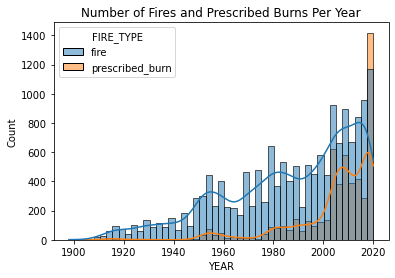

In [252]:
# plot the distribution of fires and prescribed burns by year
fires_per_year = df.groupby(['YEAR', 'FIRE_TYPE']).aggregate({'OBJECTID': 'count'}).reset_index()
sns.histplot(data=df, x = 'YEAR', hue='FIRE_TYPE', kde=True)
plt.title('Number of Fires and Prescribed Burns Per Year')
plt.show()

We are specifically interested in area burned, so we will use GIS_ACRES as a proxy.

<AxesSubplot:xlabel='GIS_ACRES', ylabel='Density'>

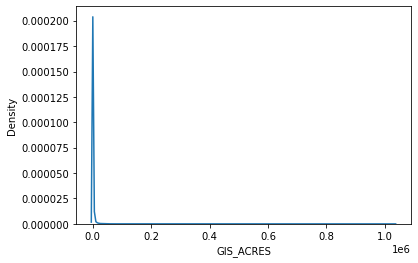

In [16]:
# plot distribution of area burned
sns.kdeplot(data=df, x='GIS_ACRES')

It seems that there are a lot of fires that are super small. Lets log normalize and see if we get a more normal distribution.

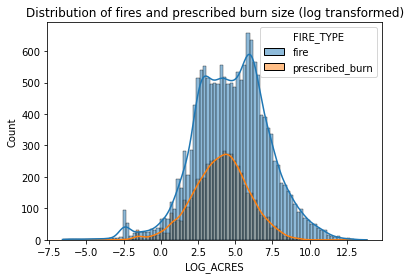

In [285]:
df['LOG_ACRES'] = df['GIS_ACRES'].apply(lambda x: np.log(x))
sns.histplot(data=df, x='LOG_ACRES', hue='FIRE_TYPE', kde=True)
plt.title('Distribution of fires and prescribed burn size (log transformed)')
plt.show()

The distribution is more normally shaped, but not centered. Not all the values make sense now because some were a fraction of an acre, but for the sake of our analysis we don't need to worry about that since we are never subtracting acreage.

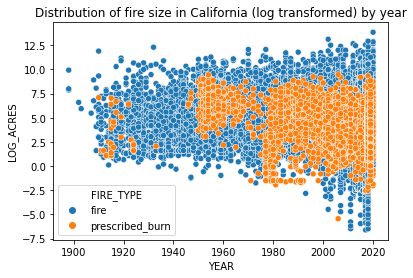

In [283]:
# plot the distribution of fire sizes by year
sns.scatterplot(data=df, x='YEAR', y='LOG_ACRES', hue='FIRE_TYPE')
plt.title('Distribution of fire size in California (log transformed) by year')
plt.show()

Knowing this is log-acres, fires and prescribed burns vary greatly in size. Prescribed burns seem to be within a set range never exceeding e^10 acres, whereas wildfires can be very small and very large. This makes sense since prescribed burns are controlled. The variance in wildfires is larger than prescribed burns. The small burns could be tiny fires that are put out quickly but are still reported.

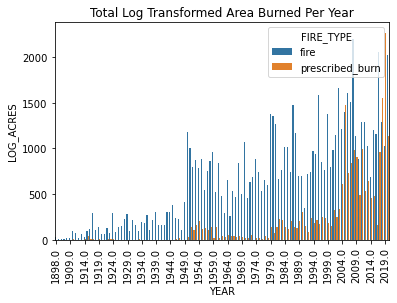

In [318]:
# How much total area has burned per year?
sns.barplot(
    data=df.groupby(['YEAR', 'FIRE_TYPE']).aggregate({'LOG_ACRES': sum}).reset_index(),
    x='YEAR',
    y='LOG_ACRES',
    hue='FIRE_TYPE',
)
plt.xticks(np.arange(0, 117, 5), rotation=90)
plt.title('Total Log Transformed Area Burned Per Year')
plt.show()

Fires oscillate over the years, but generally have increased. The same goes for prescribed burns. It appears that in recent years prescribed burns have burned as much as fires have. There could also be binning bias near the decades that may be causing these seemingly periodic trends

In [281]:
# What are common causes of fires?
df.CAUSE.value_counts()

Unknown / Unidentified      6395
Lightning                   2901
Miscellaneous               1761
Equipment Use               1225
Arson                        891
Debris                       715
Vehicle                      445
Powerline                    401
Campfire                     373
Smoking                      338
Playing with fire            195
Escaped Prescribed Burn       90
Railroad                      80
Structure                     21
Illegal Alien Campfire        17
Aircraft                      14
Non-Firefighter Training       9
Firefighter Training           2
Name: CAUSE, dtype: int64

It looks like the cause of most fires is unknown, which makes sense because probably not everyone is watching the beginning every fire. Lightning is really common in California, especially dry lightning. All in all, the incidences make sense, with the ones being most monitored, like firefighter training, or most rare, like a plane crashing, to be the least likely to occur.

To begin answering out question about whether prescribed burns have any influence on wildfires, we need to capture their interactions. One way we can do this is by building dictionaries showing which prescribed burns overlap with which fires.

Prescribed burns work when they are done within 3 years before a wildfire happens. They are a preventative measure that may even prevent a wildfire from ever occurring, and if it does occur, to a much lesser extent.

Let's first build a dictionary with all prescribed burn object IDs as keys, and values are fire object IDs that happened after the prescribed burn but overlapped in the same area.

In [33]:
# split data into prescribed burns and fires
p_burns = df.loc[df.FIRE_TYPE == 'prescribed_burn']
fires = df.loc[df.FIRE_TYPE == 'fire']

In [34]:
p_burns_area = {}
for i in range(len(p_burns)):
    burn = p_burns.iloc[i]
    p_burns_area[burn['OBJECTID']] = burn['RINGS']

fires_area = {}
for i in range(len(fires)):
    burn = fires.iloc[i]
    fires_area[burn['OBJECTID']] = burn['RINGS']

In [35]:
p_burns_polygon = {}
for k, v in p_burns_area.items():
    p_burns_polygon[k] = Polygon(v[0])
fires_polygon = {}
for k, v in fires_area.items():
    fires_polygon[k] = Polygon(v[0])

In [38]:
# get list of fires where a prescribed burn overlapped with it,
# and it happened within 3 years before the burn.
p_burn_dates = {}
for i in range(len(p_burns)):
    burn = p_burns.iloc[i]
    p_burn_dates[burn['OBJECTID']] = burn['END_DATE']

fire_dates = {}
for i in range(len(fires)):
    burn = fires.iloc[i]
    fire_dates[burn['OBJECTID']] = burn['END_DATE']

In [255]:
# Getting proportion of prescribed burn area that was burned over by a wildfire
# within 3 years after the prescribed burn.
p_burn_fire_pairs = {}

# get a sub-sample of fires to plot
fire_was_stopped = {}
counter1 = 0
fire_went_through = {}
counter2 = 0




# make dictionary for each pair and area overlap
for p in p_burns_polygon.keys():
    for f in fires_polygon.keys():
        # consider only if the fire was within 3 years after the prescribed burn
        if (0 < (fire_dates[f] - p_burn_dates[p]).days < (365*3)
            and p_burns_polygon[p].intersects(fires_polygon[f])
            ):
            # add pair to dictionary with the polygon object describing the area overlapped between the two
            identifier = (p, f)
            p_burn_fire_pairs[identifier] = p_burns_polygon[p].intersection(fires_polygon[f])
            
            # accumulate first 10 fire-burn overlaps where the fire didn't burn through
            if (counter1 < 10
                and (p_burn_fire_pairs[identifier].area / p_burns_polygon[p].area) < 0.1
               ): 
                fire_was_stopped[identifier] = GeometryCollection([p_burns_polygon[p], fires_polygon[f]])    
                counter1 += 1
            # accumulate first 10 fire-burn overlaps where the fire burned through
            if (counter2 < 10
                and p_burn_fire_pairs[identifier].area / p_burns_polygon[p].area > 0.9
               ):
                fire_went_through[identifier] = GeometryCollection([p_burns_polygon[p], fires_polygon[f]])    
                counter2 += 1

In [70]:
# how many fires occurred 3 years after a prescribed burn, and overlapped?
len(p_burn_fire_pairs)

284

In [237]:
len(p_burn_fire_pairs) / sum(df.FIRE_TYPE == 'fire')

0.017861635220125786

In [272]:
sum(df.FIRE_TYPE == 'fire')

15900

There were only 284 fires that overlapped with a recently prescribed burn area, which is about 1.8% of the total fires

Next, we will visualize the first fire-burn overlap pair geometry objects and investigate the timestamps to confirm our large script above worked properly.

In [71]:
list(p_burn_fire_pairs.items())[0]

((6174, 21680), <shapely.geometry.polygon.Polygon at 0x7f998e5b37f0>)

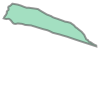

In [225]:
# prescribed burn area
p_burns_polygon[6174]

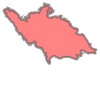

In [226]:
# fire area
fires_polygon[21680]

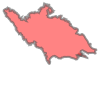

In [227]:
# both prescribed burn and fire on one plot
GeometryCollection([p_burns_polygon[6174],fires_polygon[21680]])

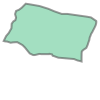

In [228]:
# Overlap region
p_burn_fire_pairs[(6174, 21680)]

In [73]:
# When did these two fires take place?
p_burn_dates[6174], fire_dates[21680]

(Timestamp('2020-06-14 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [77]:
# confirm the date range is within 3 years
(fire_dates[21680] - p_burn_dates[6174]).days

200

In [82]:
# what area of the prescribed burn area was covered by the fire?
p_burn_fire_pairs[(6174, 21680)].area / p_burns_polygon[6174].area

0.42061546181231957

In [83]:
# build a dictionary with the area of the prescribed burn that was covered by the fire for each burn.
p_burn_fire_percent_cover = {}
for k, v in p_burn_fire_pairs.items():
    p = k[0]
    f = k[1]
    percent_cover = v.area / p_burns_polygon[p].area
    
    p_burn_fire_percent_cover[k] = percent_cover

Text(0, 0.5, 'number of prescribed burns')

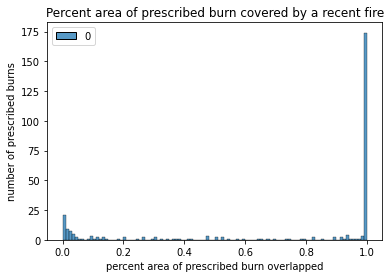

In [85]:
# distribution of fires by the proportion of the overlapping fire spread through it.
sns.histplot(p_burn_fire_percent_cover.values(), bins = 100)
plt.title('Percent area of prescribed burn covered by a recent fire')
plt.xlabel('percent area of prescribed burn overlapped')
plt.ylabel('number of prescribed burns')

The distribution of precribed burn area overcome by fire has a right and left skew, with local maxima at the extremes. There are many more prescribed burn areas that were completely overcome by a fire within 3 years after the burn than burns that theoretically "stopped" a fire from going through.

In [88]:
# what is the mean area and standard deviation of a prescribed burn covered by fire?
np.mean(list(p_burn_fire_percent_cover.values())), np.std(list(p_burn_fire_percent_cover.values()))

(0.7371679758924196, 0.3956477326228606)

On average, 74% of prescribed burn area was covered by fire

In [91]:
# proportion of prescribed burns that were completely overcome by the fires
np.mean([i > 0.99 for i in list(p_burn_fire_percent_cover.values())])

0.6126760563380281

With a threshold of at least 99% of the prescribed being covered by a recent fire, about 60% of prescribed burns had the wildfire burn through through them. This doesn't necessarily mean most were ineffective, because it could have still stopped the fire's extent

### Statistical Analysis

Do fires that overlap with prescribed burns have larger or smaller areas of overlap?

In [201]:
df.head()

,OBJECTID,YEAR,STATE,AGENCY,UNIT_ID,FIRE_NAME,START_DATE,END_DATE,CAUSE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPE_LENGTH,SHAPE_AREA,FIRE_TYPE,RINGS,LOG_ACRES,RINGS_CENTER,X_CENTER,Y_CENTER
0,21440,2020.0,CA,CDF,NEU,NELSON,2020-06-18,2020-06-23,Powerline,110.0,109.60250,1.0,4179.743142,7.331347e+05,fire,"[[[-121.34841599559529, 38.88999089961929], [-...",4.696860,"(-121.35003800145768, 38.88898228667373)",-121.350038,38.888982
1,21441,2020.0,CA,CDF,NEU,AMORUSO,2020-06-01,2020-06-04,Equipment Use,670.0,685.58502,1.0,12399.375391,4.578172e+06,fire,"[[[-121.35276437696633, 38.8203885779964], [-1...",6.530273,"(-121.36516535677205, 38.82402462873682)",-121.365165,38.824025
2,21442,2020.0,CA,CDF,NEU,ATHENS,2020-08-10,2020-03-01,Unknown / Unidentified,26.0,27.30048,1.0,2119.194120,1.823876e+05,fire,"[[[-121.33334769903689, 38.84558416014423], [-...",3.306904,"(-121.3350521059109, 38.84383671221456)",-121.335052,38.843837
3,21443,2020.0,CA,CDF,NEU,FLEMING,2020-03-31,2020-04-01,Miscellaneous,13.0,12.93155,1.0,2029.524881,8.667942e+04,fire,"[[[-121.27318028493654, 38.96308176928564], [-...",2.559670,"(-121.27336880381682, 38.96218219024024)",-121.273369,38.962182
4,21444,2020.0,CA,CDF,NEU,MELANESE,2020-04-14,2020-04-19,Escaped Prescribed Burn,10.3,10.31596,1.0,1342.742903,7.017912e+04,fire,"[[[-121.30066740042903, 39.48714167732556], [-...",2.333692,"(-121.30059183570869, 39.48627977600316)",-121.300592,39.486280


In [202]:
fires = df.loc[df['FIRE_TYPE'] == 'fire']

In [ ]:
fires

In [203]:
fires_after_p_burn = set([i[1] for i in p_burn_fire_pairs.keys()])

In [297]:
fires.loc[:, ('WITHIN_THREE_YEARS_AFTER_BURN')] = fires['OBJECTID'].apply(lambda x: x in fires_after_p_burn)

<AxesSubplot:xlabel='WITHIN_THREE_YEARS_AFTER_BURN', ylabel='GIS_ACRES'>

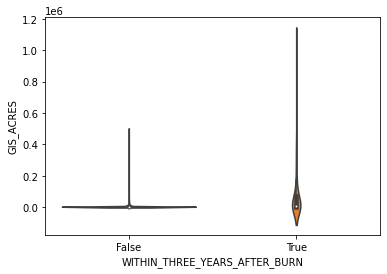

In [216]:
sns.violinplot(data=fires, x = 'WITHIN_THREE_YEARS_AFTER_BURN', y = 'GIS_ACRES')

While it is hard to compare the distribution of fire area without or log scale, this plot demonstrates that there are a lot of very small fires that did not overlap with a prescribed burn.

<AxesSubplot:xlabel='WITHIN_THREE_YEARS_AFTER_BURN', ylabel='LOG_ACRES'>

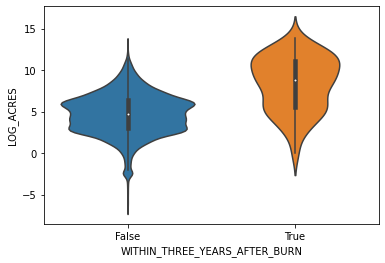

In [217]:
# get distribution of fire area log scaled
sns.violinplot(data=fires, x = 'WITHIN_THREE_YEARS_AFTER_BURN', y = 'LOG_ACRES')

Fires that happen within 3 years after a prescribed burn and collide with it seem to be larger on average. This is likely due to the fact that fires that are larger have a higher chance of coming in contact with a prescribed burn area compared to fires that are small.

### Permutation Test

We will use the KS statistic because our samples vary in distribution and size, with there being many more fires that do not overlap with a prescribed burn. This makes a non-parametric test like KS an appropriate one to use because it doesn't assume anything about the distribution of the data.

In [274]:
gpA = fires.loc[fires['WITHIN_THREE_YEARS_AFTER_BURN'] == True].LOG_ACRES
gpB = fires.loc[fires['WITHIN_THREE_YEARS_AFTER_BURN'] == False].LOG_ACRES

obs = ks_2samp(gpA, gpB).statistic
obs

0.5190657454673473

To understand how 'unusual' this value may be, we can run hundreds of simulations of shuffled data and plot the distribution against the empirical observation above.

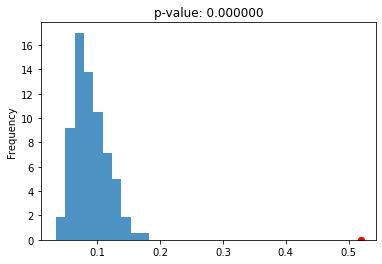

In [220]:
# run simulations and plot distribution of KS against
# emperical observation
n_repetitions = 500

ks_list = []
for _ in range(n_repetitions):
    
    # shuffle WITHIN_THREE_YEARS_AFTER_BURN
    shuffled_col = np.random.permutation(fires['WITHIN_THREE_YEARS_AFTER_BURN'].values)
    
    # put them in a table
    shuffled = (
        fires
        .assign(**{
            'WITHIN_THREE_YEARS_AFTER_BURN': shuffled_col,
        })
    )
    
    # compute the KS
    grps = shuffled.groupby('WITHIN_THREE_YEARS_AFTER_BURN')['LOG_ACRES']
    ks = ks_2samp(grps.get_group(True), grps.get_group(False)).statistic
    
    ks_list.append(ks)
    

pval = np.mean(np.array(ks_list) > obs)

pd.Series(ks_list).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)

plt.scatter(obs, 0, color='red', s=40);

Based on the above simulations, our observation is well outside the null distribution and our p-value is essentially zero. Fires that encountered recently prescribed burn areas have a significantly greater size than fires that do not encounter recently prescribed burn areas.

### Visualize a few of the fires

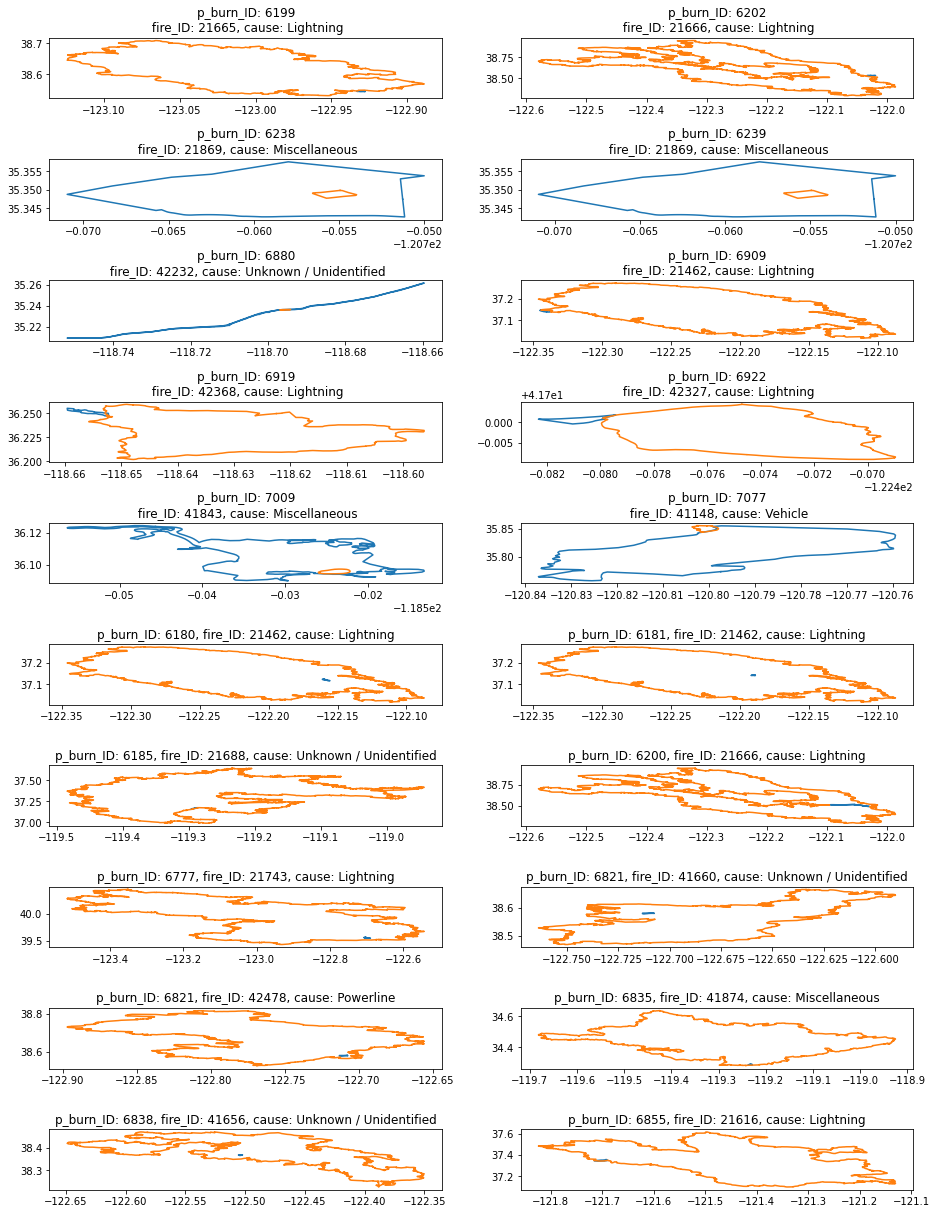

In [295]:
fig, axs = plt.subplots(10, 2)

# set up subplots matrix
coords = [(0, 0), (0, 1),
          (1, 0), (1, 1),
          (2, 0), (2, 1),
          (3, 0), (3, 1),
          (4, 0), (4, 1),
          (5, 0), (5, 1),
          (6, 0), (6, 1),
          (7, 0), (7, 1),
          (8, 0), (8, 1),
          (9, 0), (9, 1)
          
          ]
# use to index coords.
index = 0

for k, v in fire_was_stopped.items():
    p = k[0]
    f = k[1]
    c1 = coords[index][0]
    c2 = coords[index][1]
    index += 1
    axs[c1, c2].plot(*p_burns_polygon[p].exterior.xy)
    axs[c1, c2].plot(*fires_polygon[f].exterior.xy)
    axs[c1, c2].set_title('p_burn_ID: ' + str(p) + 
                          '\n fire_ID: ' + str(f) +
                          ', cause: ' + (df.loc[df['OBJECTID'] == f]['CAUSE'].iloc[0])
                         )
    
for k, v in fire_went_through.items():
    p = k[0]
    f = k[1]
    c1 = coords[index][0]
    c2 = coords[index][1]
    index += 1
    axs[c1, c2].plot(*p_burns_polygon[p].exterior.xy)
    axs[c1, c2].plot(*fires_polygon[f].exterior.xy)
    axs[c1, c2].set_title('p_burn_ID: ' + str(p) + 
                          ', fire_ID: ' + str(f) +
                          ', cause: ' + (df.loc[df['OBJECTID'] == f]['CAUSE'].iloc[0])
                         )

plt.subplots_adjust(
    left=0,
    right=2,
    bottom=0,
    top=4,
    wspace=0.2,
    hspace=1
)
plt.show()

Of the 20 fires, prescribed burns tend to be much smaller than fires. However, in some instances where the prescribed burn seems to have prevented the fire from spreading, the fire is much smaller and within the prescribed burn area. We don't have a lot of information but it may have prevented the fire from spreading more quickly so firefighters could get to it (it needed to have still been witnessed to be recorded). Most fires are extremely large compared to prescribed burns and burned through the area.

Let's take a look at more of the prescribed burns where the fires did not burn through. It's important to visualize these to get an idea of if the fire was stopped, or if some other factors such as firefighting may have played a larger role. For example, if a fire of comparable size to the prescribed burn doesn't spread past the burn area, but may be spreading in other directions, that may be a good indication the prescribed burn stopped the spread of the fire.

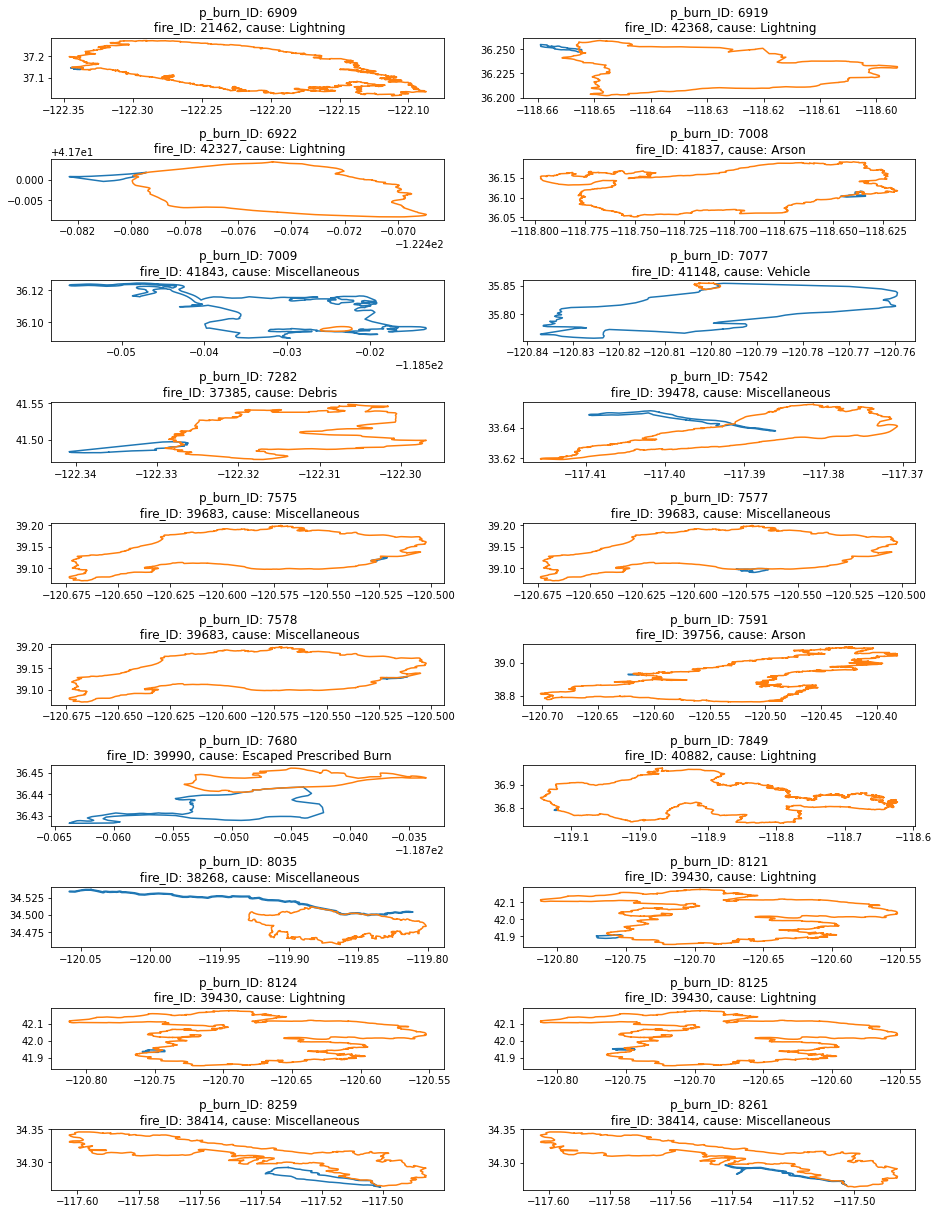

In [343]:
# build a list containing prescribed burn fire pairs
# with 50% or less coverage of prescribed burn area.
half_or_less = []
for k,v in p_burn_fire_percent_cover.items():
    if v < 0.5:
        half_or_less.append(k)

fig, axs = plt.subplots(10, 2)

# set up subplots matrix
coords = [(0, 0), (0, 1),
          (1, 0), (1, 1),
          (2, 0), (2, 1),
          (3, 0), (3, 1),
          (4, 0), (4, 1),
          (5, 0), (5, 1),
          (6, 0), (6, 1),
          (7, 0), (7, 1),
          (8, 0), (8, 1),
          (9, 0), (9, 1)
          ]
# use to index coords.
index = 0

# investigate new fires not from the first visualization
for k in half_or_less[6:26]:
    p = k[0]
    f = k[1]
    c1 = coords[index][0]
    c2 = coords[index][1]
    index += 1
    axs[c1, c2].plot(*p_burns_polygon[p].exterior.xy)
    axs[c1, c2].plot(*fires_polygon[f].exterior.xy)
    axs[c1, c2].set_title('p_burn_ID: ' + str(p) + 
                          '\n fire_ID: ' + str(f) +
                          ', cause: ' + (df.loc[df['OBJECTID'] == f]['CAUSE'].iloc[0])
                         )

plt.subplots_adjust(
    left=0,
    right=2,
    bottom=0,
    top=4,
    wspace=0.2,
    hspace=1
)
plt.show()

Some burns seem to have stopped the spread of the fire. Highlights include p_burn #7782 and fire #37385, where the fire seems to have burned around the prescribed burn area. Another example is p_burn #8035 and fire #38268, where a long strip of area was burned and prevented the fire from burning through.

Other instances though, such as p_burn #8125 and fire #39430, the fire was so large and may have overlapped by chance.

What is the distribution of all fires and prescribed burns across california?

In [124]:
# get center of each fire to reduce computational cost
p_burn_centers = [p_burns_polygon[f].centroid for f in p_burns_polygon.keys()]
fire_centers = [fires_polygon[f].centroid for f in fires_polygon.keys()]

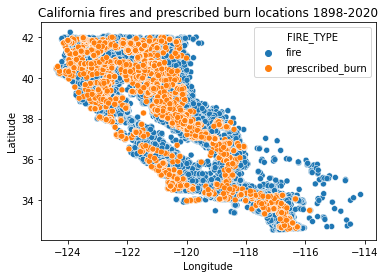

In [337]:
# Find the center of each fire from 'rings', which contains a list of coordinates
# describing the area of the fire.

def get_mean_coords(rings):
    """
    A function that takes in a list of GIS coordinates that form a ring and
    returns the center point by averaging the X values and Y values as a tuple.
    """
    unnested = rings[0]
    x = [i[0] for i in unnested]
    y = [i[1] for i in unnested]
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return (x_mean, y_mean)

df['RINGS_CENTER'] = df['RINGS'].apply(get_mean_coords)

# create columns describing the x and y coordinates that define the center of the fire
df['X_CENTER'] = df['RINGS_CENTER'].apply(lambda x: x[0])
df['Y_CENTER'] = df['RINGS_CENTER'].apply(lambda x: x[1])

# plot the distribution of fires by fire type (wildfires or prescribed burns)
sns.scatterplot(data=df, x = 'X_CENTER', y = 'Y_CENTER', hue='FIRE_TYPE')
plt.title('California fires and prescribed burn locations 1898-2020')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


While we did not use any specific geographic plotting software, a scatterplot can still capture the rough shape of California and where the fires took place relative to one another. Here we can see that prescribed burns have been conducted all across California. There are some areas where they haven't happened, but it's possible they do happen and are not reported. No fires in the central valley makes sense because it's mostly farmland and hills with no trees, where the ground is frequently monitored and wet. There are lots of fires in the Sierra Nevada Region, which has lots of forests and is drier, and in the LA county area. Lots of prescribed burns are done in the Sierra Nevada. There are also no fires in the southeast likely because it's mostly desert. (Credit to Michael Lwin Dumont (ChemEng 2022) for geographical interpretation consult)

Now, let's plot the California state boundaries around it to give a better representation of where the fires are occurring.

In [331]:
shape = geopandas.read_file("ca-state-boundary/CA_State_TIGER2016.shp")

In [332]:
# investigate what coordinate system it's coded in
shape.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [333]:
# change to 4326, the coordinate system of our fire data (from ARC GIS documentation)
shape['geometry'] = shape['geometry'].to_crs(epsg=4326)

In [334]:
shape['geometry']

0    MULTIPOLYGON (((-119.63473 33.26545, -119.6363...
Name: geometry, dtype: geometry

The datatype is multipolygon, so we need to plot all of the shapes. It likely means there is california, but also the islands off of it. It's important to include these because our previous plot above shows there were likely fires on those areas too

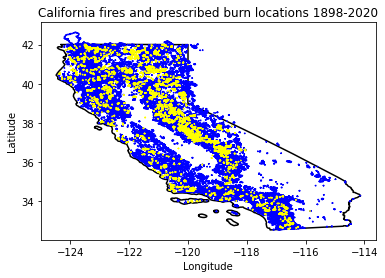

In [336]:
# plot california boundaries in grey
for g in shape['geometry'][0].geoms:
    plt.plot(*g.exterior.xy, color='black')
# plot the fires in blue
for k,v in fires_polygon.items():
    plt.plot(*v.exterior.xy, color='blue')
# plot prescribed burns in orange
for k,v in p_burns_polygon.items():
    plt.plot(*v.exterior.xy, color='yellow')
plt.title('California fires and prescribed burn locations 1898-2020')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Main Findings

- The amount of area burned from wildfires in California has increased since records began.
- The number of wildfires have increased, but prescribed burn efforts have also increased, especially in the past 20 years.
- Many fires were caused by lightning. Dry lightning is very common in California.
- There were no fires in the central valley, where a lot of farming takes place.
- Most prescribed burns occurred along the Sierra Nevada mountain range.
- Only 284 out of 15,900 wildfires (~1.8%) overlapped with a prescribed burn that happened within three years before the fire.
- 73% of the total prescribed burn area was overcome by a fire within three years after the prescribed burn.
- ~61% of prescribed burns were more than 99% overcome by a fire within three years after the prescribed burn.
- The prescribed burns were often much smaller than the fires they bordered, but in some cases, such as with prescribed burn #6329 and fire #21869, the fire occurred within the prescribed burn area and did not spread.
- Fires that overlap with areas that were recently treated with prescribed burns are generally larger than fires that did not encounter prescribed burn areas.


# Ethics & Privacy

The data used in our research does not have conflicts with privacy or terms of use agreements because we are not collecting any personal data. All of the data used has been published online by CalFire and is readily accessible to all; therefore, we did not infringe on anyone’s privacy. 

Considering the credibility of this government website, we believe that they provide accurate and unfabricated data. Although we aim to minimize biases in our data, confounding factors do exist. We found that fires which occurred within three years after a prescribed burn and overlapped with prescribed burn areas were larger on average. This may be attributed to the fact that larger fires have a higher chance of overlapping with prescribed burn regions simply due to their magnitude. It's also possible that prescribed burns have prevented many fires from starting by removing potential sites of ignition, which we cannot quantify with our limited analysis.

# Conclusion & Discussion

From our analysis, prescribed burns have some effect on decreasing the spread of wildfires if the prescribed burn and fire are of similar sizes. Looking at examples of fire-burn interactions, some fires that started in an area previously treated with prescribed burns did not spread. In other regions, the prescribed burn may have prevented the fire from spreading further; however, the incidences were so low that it could have been a coincidence that some large fires would happen to overlap only partially with recent prescribed burn areas. Visual images of the fire and prescribed burn area would help us understand if the fire did not spread through because of the prescribed burn, or if other variables such as firefighting or rain were the main reason the fire stopped at the prescribed burn.

Many more fires burned through prescribed burn areas. These fire areas were many magnitudes larger than the prescribed burn area that they overcame. The effectiveness of prescribed burns relies on it being able to starve the fire by clearing the tinder. If the fire is extremely large compared to the prescribed burn, there is enough tinder for the fire to go around the prescribed burn, rendering it ineffective. It's possible these fires started out much further away and were large by the time they reached the burn area, whereas fires of comparable size to the prescribed burn may have originated in a much closer area to the burn, such that the burn could effectively starve the fire of fuel to continue growing.

One major limitation of our analysis is that we only had 241 fires out of 15900 that overlapped with prescribed burns. This could be that many prescribed burns were effective in that they prevented the initiation of many fires, and thus we wouldn't see any overlap, but does not directly help us answer our question about how effective they are at preventing the spread of fires once they start. Another thing to consider is that prescribed burns generally refer to burning away the buildup of tinder in the understory, while larger trees in the overstory remain standing. Large fires may be so hot that they can spread through the overstory, rendering the prescribed burn more obsolete in preventing the spread of the fire across the landscape.

Due to our limited number of fire-prescribed burn pairs, we didn't have enough data to look at effectiveness across different types of prescribed burns, such as broadcast burning, fuels reduction. These features were also missing in many observations, so a larger and more complete dataset would be needed to draw more nuanced conclusions about the effectiveness of prescribed burns in preventing the spread of wildfire.

Future studies could include fires that move over recently burned areas by other wildfires and include them in the fire interaction pairs because they would have a similar effect to prescribed burns. Another way to have more data to draw deeper conclusions would be to include more regions besides California in the analysis.

# Team Contributions

Laticia Long
- Helped with literature review, introduction, references,
- Went to office hours often to ask questions about project
- Helped with early EDA describing mean, standard dev. of different features
- Helped make final video

Michael Colbath
- Data cleaning the CSV datasets and attaching the rings portion to make our final dataset
- Some EDA
- Final assembly, bugfixes, and cleanup of datacleaning and EDA
- Helped make final video

Sungjun Kim
- Pair-programmed with James on Shapely plots
- Helped make final video

James Riddell
- Helped write question, hypotheses, introduction, and literature review
- Performed second half of data cleaning: scraped GIS coordinate data using ARCGIS API
- Did exploratory data analysis, statistical analysis, and results; made all figures
- Collaborated with Sungjun on Shapely plots
- Cleaned up graphs to include titles and interpretations
- Wrote the conclusion and discussion
- Helped make final video